In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the data
ultra_marathon_loc = os.path.join(os.getcwd(), 'data', 'ultra_marathon.csv')
# ultra_marathon = pd.read_csv(ultra_marathon_loc, nrows=500000) # Reading 500k rows for faster testing
ultra_marathon = pd.read_csv(ultra_marathon_loc)
print("The .csv has been loaded.")



#_____________________________Clean the data_____________________________________


# Rename columns
ultra_marathon.rename(columns={
    'Year of event':                'Year',         # int
    'Event dates':                  'Dates',        # [datetime]
    'Event name':                   'Event_name',   # str
    'Event distance/length':        'Length',       # str; (km, mi or hours)
    'Event number of finishers':    'Finishers',    # int
    'Athlete performance':          'Performance',  # str; (km, mi or hours)
    'Athlete club':                 'Club',         # str
    'Athlete country':              'Country',      # str
    'Athlete year of birth':        'Birth',        # float
    'Athlete gender':               'Gender',       # int (M=0, F=1)
    'Athlete age category':         'Age',          # int
    'Athlete average speed':        'Average_speed',# float
    'Athlete ID':                   'Id'            # int
}, inplace=True)



# Drop entries with null values
# print(ultra_marathon.isnull().sum())
ultra_marathon.dropna(subset=['Age', 'Birth'], inplace=True)


# Remove unnecesary information
ultra_marathon['Age'] = ultra_marathon['Age'].str.extract(r'(\d+)')
allowed_values = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']
ultra_marathon = ultra_marathon[ultra_marathon['Length'].isin(allowed_values)]
ultra_marathon = ultra_marathon[ultra_marathon['Gender'].notna() & (ultra_marathon['Gender'] != 'X')] # Eliminate the X and nan values
ultra_marathon['Gender'] = ultra_marathon['Gender'].map({'M': 0, 'F': 1}) # Encode gender to 0 and 1


# Parse into numeric data types
ultra_marathon['Year']          = pd.to_numeric(ultra_marathon['Year'], errors='coerce')
ultra_marathon['Finishers']     = pd.to_numeric(ultra_marathon['Finishers'], errors='coerce')
ultra_marathon['Birth']         = pd.to_numeric(ultra_marathon['Birth'], errors='coerce')
ultra_marathon['Age']           = pd.to_numeric(ultra_marathon['Age'], errors='coerce')
ultra_marathon['Average_speed'] = pd.to_numeric(ultra_marathon['Average_speed'], errors='coerce')
ultra_marathon['Id']            = pd.to_numeric(ultra_marathon['Id'], errors='coerce', downcast='integer')


# Custom parsing (Currently disabled)

def parseDates(given_string):
    # The possible formats are: '00.01.2000', '01.-05.01.2000', '31.01.-01.02.2000', '31.12.2000-01.01.2001'
    try:
        return [datetime.strptime(given_string, "%d.%m.%Y")]
    except:
        pass
    try:
        interval = given_string.split('-')
        for separation_length in [3, 6, 10]:
            if len(interval[0]) == separation_length:
                first_day = datetime.strptime(interval[0] + interval[1][separation_length:], "%d.%m.%Y")
                last_day = datetime.strptime(interval[1], "%d.%m.%Y")
                # return [first_day + timedelta(days=i) for i in range((last_day - first_day).days + 1)]
                return [first_day, last_day]
    except:
        # None parsable & existent dates such as 00.01.2000
        return None


# Returns (int value, int stages), where stage=0 indicates hours and any other stage indicates number of race stages
def parseLengths(given_string):
    if pd.isna(given_string):
        return (np.nan, np.nan)
    
    if "h" in given_string:
        try:
            return(float(re.search(r'(\d+)h', given_string)[1]), 0)
        except AttributeError:
            return (np.nan, np.nan)

    if "mi" in given_string:
        distance = round((1.60934 * float(re.search(r'(\d+(\.\d+)?)mi', given_string)[1])), 2)
    else:
        distance = float(re.search(r'(\d+(\.\d+)?)km', given_string)[1])
    stages = re.search(r'(\d+)Etappen', given_string)

    try:
        if stages == None:
            return (distance, 1)
        else:
            return (distance, int(stages[1]))
    except:
        return (np.nan, np.nan)
    
# Apply custom parsing (currently disabled)
# ultra_marathon['Dates'] = ultra_marathon['Dates'].apply(parseDates)
# ultra_marathon[['Length', 'Stages']] = ultra_marathon['Length'].apply(parseLengths).apply(pd.Series)


# Recast column types (reduces memory usage by 25%)
ultra_marathon['Year'] = ultra_marathon['Year'].astype(pd.Int16Dtype())
ultra_marathon['Finishers'] = ultra_marathon['Finishers'].astype(pd.Int32Dtype())
ultra_marathon['Birth'] = ultra_marathon['Birth'].astype(pd.Int16Dtype())
ultra_marathon['Gender'] = ultra_marathon['Gender'].astype(pd.Int8Dtype())
ultra_marathon['Age'] = ultra_marathon['Age'].astype(pd.Int8Dtype())
ultra_marathon['Average_speed'] = ultra_marathon['Average_speed'].astype(pd.Float32Dtype())


# Display information
print(ultra_marathon.info())
ultra_marathon.head(3)


/var/folders/3_/ymn7dyh91yn_mzg9vpnv7qq00000gn/T/ipykernel_32007/3910797947.py:12: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  ultra_marathon = pd.read_csv(ultra_marathon_loc)


The .csv has been loaded.
<class 'pandas.core.frame.DataFrame'>
Index: 3193826 entries, 0 to 7461194
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           Int16  
 1   Dates          object 
 2   Event_name     object 
 3   Length         object 
 4   Finishers      Int32  
 5   Performance    object 
 6   Club           object 
 7   Country        object 
 8   Birth          Int16  
 9   Gender         Int8   
 10  Age            Int8   
 11  Average_speed  Float32
 12  Id             int32  
dtypes: Float32(1), Int16(2), Int32(1), Int8(2), int32(1), object(6)
memory usage: 243.7+ MB
None


,Year,Dates,Event_name,Length,Finishers,Performance,Club,Country,Birth,Gender,Age,Average_speed,Id
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978,0,35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981,0,35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987,0,23,9.472,2


In [4]:
# Data exploration

print(ultra_marathon.info())

# Summary statistics
print(ultra_marathon.describe(include='all')) # include='all' includes non-numeric columns

# print unique values for categorical columns
print('Event name:', ultra_marathon['Event_name'].unique())
print('Length:', ultra_marathon['Length'].unique())
print('Club:', ultra_marathon['Club'].unique())
print('Country:', ultra_marathon['Country'].unique())
print('Gender:', ultra_marathon['Gender'].unique())

print(ultra_marathon['Average_speed'].head(10))
# print the highest average speed
print(ultra_marathon['Average_speed'].max())
# print the median average speed
print(ultra_marathon['Average_speed'].median())
# print the shape of the dataframe
print(ultra_marathon.shape)
# print the number of rows with average speed below 20
print(ultra_marathon[ultra_marathon['Average_speed'] < 20].shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 3193826 entries, 0 to 7461194
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           Int16  
 1   Dates          object 
 2   Event_name     object 
 3   Length         object 
 4   Finishers      Int32  
 5   Performance    object 
 6   Club           object 
 7   Country        object 
 8   Birth          Int16  
 9   Gender         Int8   
 10  Age            Int8   
 11  Average_speed  Float32
 12  Id             int32  
dtypes: Float32(1), Int16(2), Int32(1), Int8(2), int32(1), object(6)
memory usage: 243.7+ MB
None
               Year       Dates              Event_name   Length    Finishers  \
count     3193826.0     3193826                 3193826  3193826    3193826.0   
unique         <NA>       10025                   15230       11         <NA>   
top            <NA>  20.04.2019  100 km Lauf Biel (SUI)     50km         <NA>   
freq           <NA>       14891                   

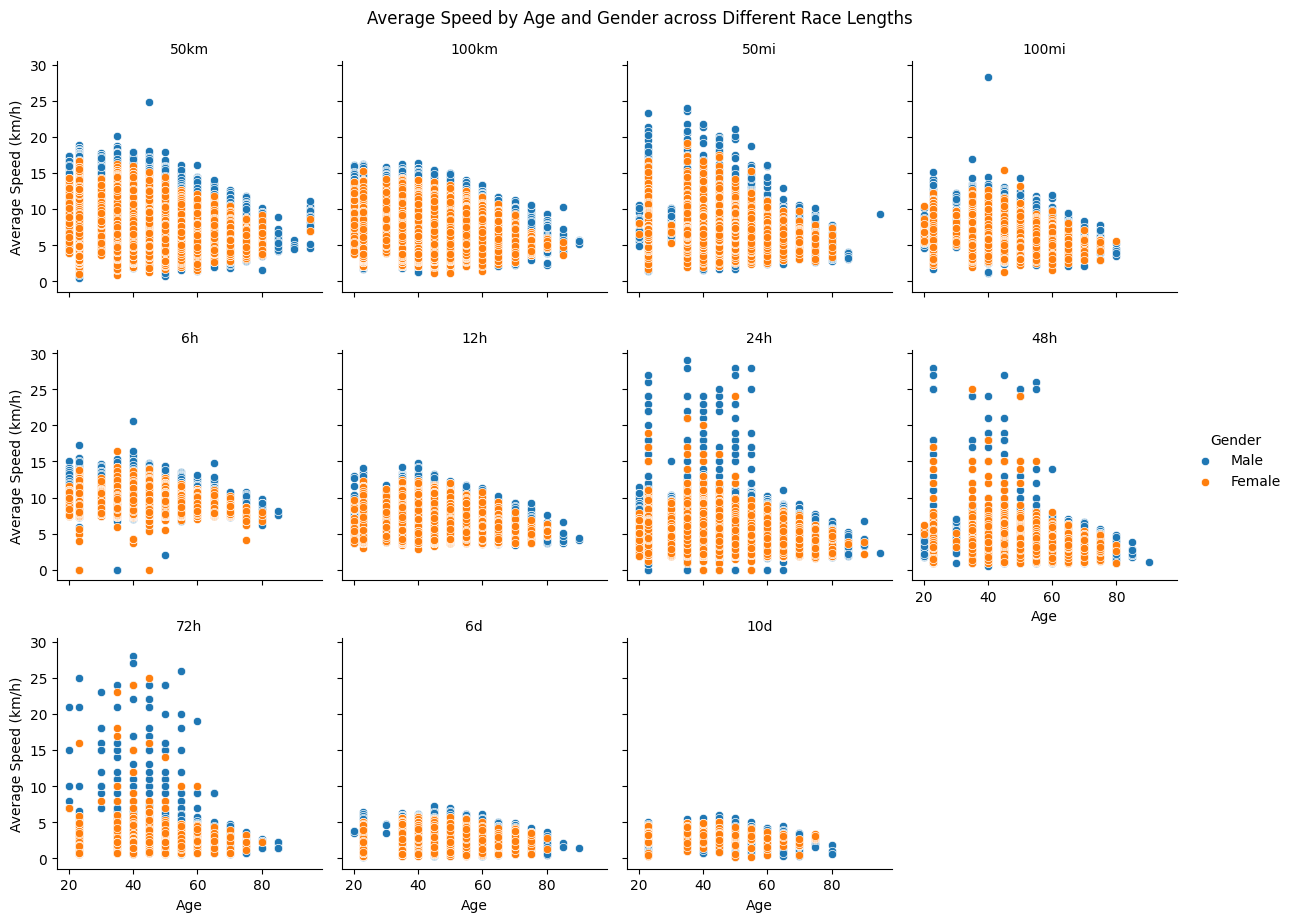

In [7]:
# Explore how perforamnce change based on distance and demographics
# Scatter plot

# Copy the dataframe
performance = ultra_marathon.copy()

# Drop the values of average speed that are above 30
performance = performance[performance['Average_speed'] < 30]

# Define the order for "Length" based on the provided list
length_order = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']

# Ensure the Length column is categorical and ordered
performance['Length'] = pd.Categorical(performance['Length'], categories=length_order, ordered=True)

# Sort the DataFrame by the Length to respect the order in the plot
performance = performance.sort_values(by='Length')

# Map gender to strings
gender_map = {0: 'Male', 1: 'Female'}
performance['Gender'] = performance['Gender'].map(gender_map)

# Create a FacetGrid, plotting average speed by age for each gender across different race lengths
g = sns.FacetGrid(performance, col='Length', hue='Gender', col_wrap=4, height=3, sharex=True, sharey=True)
g.map(sns.scatterplot, 'Age', 'Average_speed')

# Add some aesthetic adjustments and titles
g.add_legend(title='Gender')
g.set_axis_labels('Age', 'Average Speed (km/h)')
g.set_titles("{col_name}")
g.fig.suptitle('Average Speed by Age and Gender across Different Race Lengths', y=1.02)

# Show the plot
plt.show()

Text(0, 0.5, 'Average Speed (km/h)')

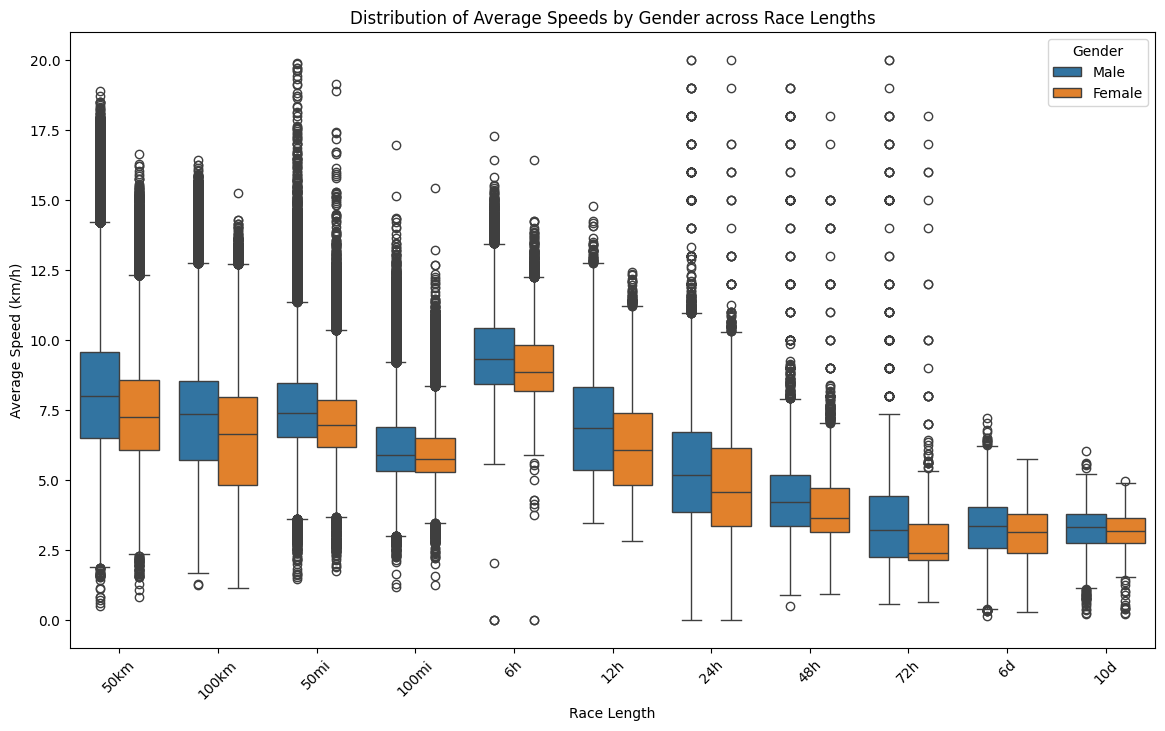

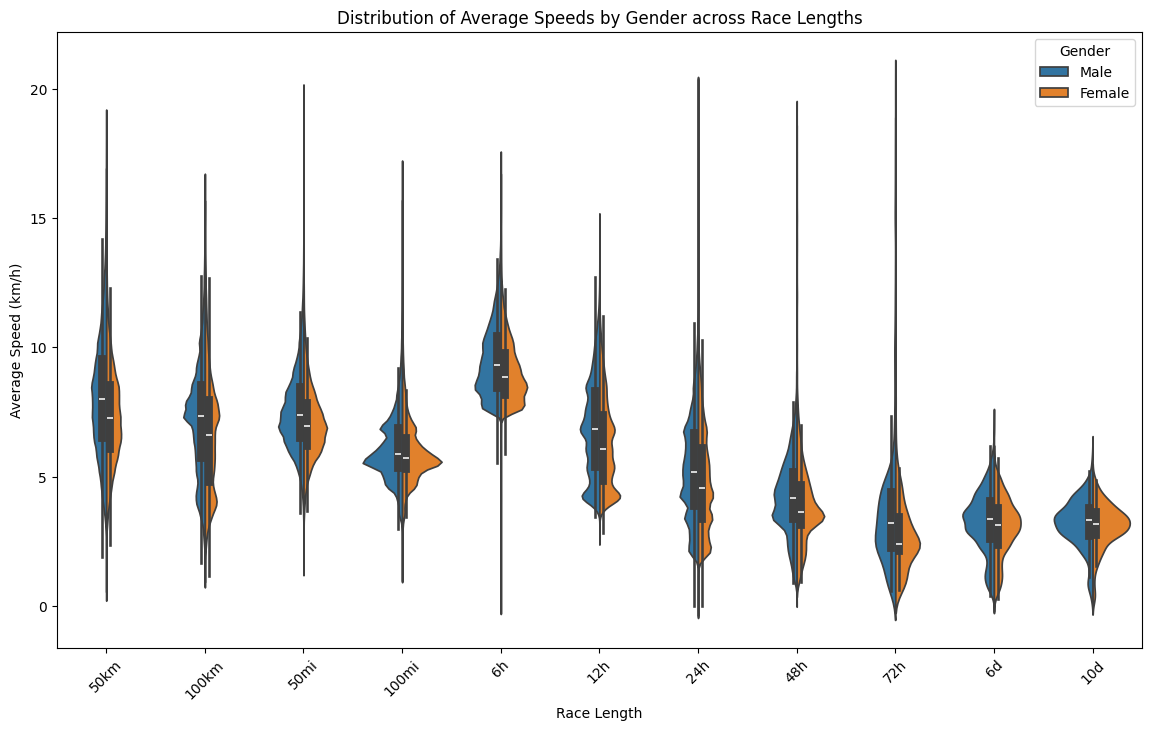

In [8]:
# Explore how perforamnce change based on distance and demographics
# Box plot and violin plot

# Copy the dataframe
performance = ultra_marathon.copy()

# Drop the values of average speed that are above 30
performance = performance[performance['Average_speed'] <= 20]

# Define the order for "Length" based on the provided list
length_order = ['50km', '100km', '50mi', '100mi', '6h', '12h', '24h', '48h', '72h', '6d', '10d']

# Ensure the Length column is categorical and ordered
performance['Length'] = pd.Categorical(performance['Length'], categories=length_order, ordered=True)

# Sort the DataFrame by the Length to respect the order in the plot
performance = performance.sort_values(by='Length')

# Map gender to strings
gender_map = {0: 'Male', 1: 'Female'}
performance['Gender'] = performance['Gender'].map(gender_map)

# Box Plot
plt.figure(figsize=(14, 8))
sns.boxplot(data=performance, x='Length', y='Average_speed', hue='Gender')
plt.xticks(rotation=45)
plt.title('Distribution of Average Speeds by Gender across Race Lengths')
plt.xlabel('Race Length')
plt.ylabel('Average Speed (km/h)')

# Violin Plot
plt.figure(figsize=(14, 8))
sns.violinplot(data=performance, x='Length', y='Average_speed', hue='Gender', split=True)
plt.xticks(rotation=45)
plt.title('Distribution of Average Speeds by Gender across Race Lengths')
plt.xlabel('Race Length')
plt.ylabel('Average Speed (km/h)')

In [ ]:
# Graphs to explore the data

# analyze how many finisher there are per year
finishers_per_year = ultra_marathon.groupby('Year')['Finishers'].sum()
sns.lineplot(x=finishers_per_year.index, y=finishers_per_year.values)
# print the minimum and maximum number of finishers
print(finishers_per_year.idxmin(), finishers_per_year.min())
# print the year with the maximum number of finishers
print(finishers_per_year.idxmax(), finishers_per_year.max())
# see the outliers using a boxplot (x-axis is the year (by decade) and y-axis is the number of finishers)
sns.boxplot(x=ultra_marathon['Year']//20*20, y=ultra_marathon['Finishers'])
# print number of finisher per decade
print(ultra_marathon.groupby(ultra_marathon['Year']//10*10)['Finishers'].sum())
# print number of finisher for the last decade (year by year)
print(ultra_marathon[ultra_marathon['Year'] > 2010].groupby('Year')['Finishers'].sum())

In [ ]:
# Explore the gender distribution in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Extract the decade from the 'Year' column
ultra_marathon_copy['Decade'] = ultra_marathon_copy['Year'] // 10 * 10

# Group by decade and gender, and count the number of occurrences
gender_distribution = ultra_marathon_copy.groupby(['Decade', 'Gender']).size()

# Calculate the total number of occurrences per decade
total_per_decade = gender_distribution.groupby('Decade').sum()

# Calculate the percentage of each gender per decade
percentage_per_decade = gender_distribution / total_per_decade * 100

# To print the gender distribution per decade as a percentage
print(percentage_per_decade)

# Preparing data for plotting
# Reset index to convert the Series into a DataFrame
percentage_df = percentage_per_decade.reset_index(name='Percentage')

# Plotting
# Now we plot 'Percentage' against 'Decade' with 'Gender' as the hue.
plt.figure(figsize=(10, 6)) 
# Replace 0 with 'Male' and 1 with 'Female' in the 'Gender' column of percentage_df for better visualization
percentage_df['Gender'] = percentage_df['Gender'].replace({0: 'Male', 1: 'Female'})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_df, x='Decade', y='Percentage', hue='Gender')
plt.title('Gender Distribution per Decade in Ultra Marathons')
plt.ylabel('Percentage')
plt.xlabel('Decade')
plt.show()



In [ ]:
# Explore the clubs in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Drop rows with missing values in the 'Club' column
ultra_marathon_copy.dropna(subset=['Club'], inplace=True)

# Drop duplicates to ensure each member is only counted once per club
unique_members_per_club = ultra_marathon_copy.drop_duplicates(subset=['Id', 'Club'])

# Now, count the occurrences (which represent unique members now) of each club
unique_club_distribution = unique_members_per_club['Club'].value_counts()

# Print the top 10 clubs with the most unique members
print(unique_club_distribution.head(10))

# Plot the top 10 clubs with the most unique members
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_club_distribution.head(10).values, y=unique_club_distribution.head(10).index)
plt.title('Top 10 Clubs with the Most Unique Members in Ultra Marathons')
plt.xlabel('Number of Unique Members')
plt.ylabel('Club')
plt.show()

In [ ]:
# Explore the most popular events in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Group by 'Event_name' and count the number of occurrences
event_distribution = ultra_marathon_copy['Event_name'].value_counts()

# Print the top 10 events with the most participants
print(event_distribution.head(10))

# Plot the top 10 events with the most occurrences and the year of the event
plt.figure(figsize=(10, 6))
sns.barplot(x=event_distribution.head(10).values, y=event_distribution.head(10).index)
plt.title('Top 10 Events with the Most Occurrences in Ultra Marathons')
plt.xlabel('Number of Occurrences')
plt.ylabel('Event')
plt.show()


In [ ]:
# Explore the countries with the most participants in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Group by 'Country' and count the number of occurrences
country_distribution = ultra_marathon_copy['Country'].value_counts()

# Print the top 10 countries with the most participants
print(country_distribution.head(10))

# Plot the top 10 countries with the most participants
plt.figure(figsize=(10, 6))
sns.barplot(x=country_distribution.head(10).values, y=country_distribution.head(10).index)
plt.title('Top 10 Countries with the Most Participants in Ultra Marathons')
plt.xlabel('Number of Participants')
plt.ylabel('Country')
plt.show()

In [ ]:
# Explore the age distribution in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Drop rows with missing values in the 'Age' column
ultra_marathon_copy.dropna(subset=['Age'], inplace=True)

# Get the top 10 age groups
top_10_age_groups = ultra_marathon_copy['Age'].value_counts().head(10).index

# Filter the DataFrame for the top 10 age groups
ultra_marathon_top_10_age = ultra_marathon_copy[ultra_marathon_copy['Age'].isin(top_10_age_groups)]

# Plot the age distribution for the top 10 age groups
plt.figure(figsize=(10, 6))
sns.histplot(ultra_marathon_top_10_age['Age'], kde=True)
plt.title('Age Distribution for Top 10 Age Groups in Ultra Marathons')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()
                                           